In [1]:
import numpy as np
import pandas as pd
import sys
from datetime import datetime
import skmap_bindings
from minio import Minio
import time
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from eumap import gapfiller
from eumap import parallel
from eumap.misc import find_files
from eumap.misc import nan_percentile
from eumap.misc import ttprint
from eumap.parallel import job
from eumap.parallel import TaskSequencer
from eumap.raster import read_rasters, save_rasters
from pathlib import Path
from rasterio.windows import Window
from urllib.request import urlretrieve
import bottleneck as bn
import geopandas as gpd
import math
import numpy as np
import tempfile
import os
import gc
import pandas as pd
import rasterio
import re
import requests
import shutil
import sys
import tempfile
import traceback
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
def _base_raster(raster_files):
    for r in raster_files:
        try:
            rasterio.open(r)
            return r
        except:
            continue
    return None

def _s3_find(s3_config, search_path, search_pattern, recursive = True):
  
    client = Minio(s3_config['host'], s3_config['access_key'], 
        s3_config['secret_access_key'], secure=False)

    search_path = str(search_path)
    objects = client.list_objects(s3_config['read_bucket'], prefix=search_path, recursive=recursive)
    result = []
    for obj in objects:
        if re.search(search_pattern, obj.object_name):
            result.append(Path(f'{obj.object_name}'))
    
    if len(result) == 0:
        dummy = 'MOD13Q1.A' + ''.join(search_pattern.split('.*')) + '.dummy'
        result.append(search_path + '/' + dummy)
        
    return result

def make_tempdir(basedir='skmap', make_subdir = True):
    tempdir = Path(TMP_DIR).joinpath(basedir)
    if make_subdir: 
        name = Path(tempfile.NamedTemporaryFile().name).name
        tempdir = tempdir.joinpath(name)
    tempdir.mkdir(parents=True, exist_ok=True)
    return tempdir

def _s3_tifs(s3_config, tile, band, start_year=2000, end_year=2021, time_resolution=16):
    
    s3_tifs = []
    
    args = []
    for year in range(start_year, end_year+1):
        for doy in range(1, 365, time_resolution):
            sdoy = str(doy).zfill(3)
            search_path = Path(f'{year}').joinpath(f'{tile}')
            search_pattern = f'{year}{sdoy}.*{tile}.*{band}'
            # print(search_path, f'.*{search_pattern}.*.tif')
            
            args.append((s3_config, search_path, f'.*{search_pattern}.*.tif'))
    base_url = f"http://{s3_config['host']}/{s3_config['read_bucket']}"
    for files in job(_s3_find, args, n_jobs=10):
    #print(len(files))
        for file in files:
            s3_tifs.append(f'{base_url}/{file}')
    s3_tifs.sort()

    return s3_tifs

    


def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

modis_tiles = ['h35v09','h28v03','h19v03','h21v02','h16v02','h14v11','h28v04','h03v09','h15v05','h32v08','h30v09','h30v13','h12v05','h15v03','h13v14','h09v05','h05v13','h11v07','h25v04','h32v07','h23v04','h09v09','h09v08','h19v05','h28v07','h20v11','h21v09','h17v05','h12v09','h19v08','h00v10','h17v07','h08v04','h22v04','h16v12','h12v02','h11v06','h08v08','h10v08','h20v04','h09v07','h14v03','h32v11','h17v02','h18v00','h12v08','h05v11','h16v14','h21v03','h23v02','h02v09','h35v08','h25v03','h31v08','h26v03','h24v03','h20v08','h21v08','h11v11','h13v11','h24v07','h15v00','h16v00','h30v06','h27v09','h01v07','h01v11','h27v14','h30v07','h18v01','h23v01','h31v06','h21v13','h26v07','h30v11','h20v03','h21v10','h31v10','h27v12','h22v01','h10v04','h22v10','h17v04','h13v10','h22v09','h23v08','h16v05','h34v10','h11v05','h04v10','h19v06','h29v07','h07v07','h13v09','h30v05','h09v02','h29v10','h18v07','h18v06','h09v04','h14v10','h27v08','h20v00','h27v11','h16v09','h12v13','h12v07','h34v09','h04v09','h30v12','h20v02','h21v00','h32v10','h10v02','h18v08','h33v11','h18v03','h27v04','h22v11','h19v04','h20v12','h20v10','h11v02','h15v02','h08v11','h33v08','h29v08','h29v11','h25v05','h10v03','h31v09','h24v04','h28v11','h14v00','h11v04','h22v05','h08v09','h35v10','h28v06','h10v06','h14v14','h33v07','h12v12','h20v13','h24v02','h28v12','h20v09','h17v01','h28v09','h17v10','h12v04','h27v06','h11v08','h25v08','h25v06','h13v13','h21v01','h06v03','h29v13','h29v05','h24v12','h32v12','h27v03','h18v14','h14v09','h17v00','h25v02','h22v13','h29v09','h20v05','h20v01','h09v06','h22v14','h01v09','h10v11','h02v10','h28v08','h11v12','h08v06','h22v02','h28v10','h17v12','h27v05','h30v08','h03v10','h21v05','h22v03','h26v02','h23v06','h17v03','h19v00','h31v12','h28v13','h08v07','h19v01','h29v12','h24v06','h17v08','h10v10','h13v12','h17v13','h09v03','h26v06','h12v03','h14v02','h10v07','h21v07','h07v05','h21v06','h02v06','h19v12','h31v07','h15v07','h06v11','h15v01','h01v08','h19v02','h16v08','h04v11','h10v05','h23v07','h26v04','h07v06','h16v06','h30v10','h12v11','h16v01','h13v03','h00v08','h00v09','h19v11','h27v10','h11v03','h23v11','h21v04','h02v08','h16v07','h02v11','h18v05','h25v09','h22v07','h20v06','h20v07','h07v03','h22v08','h11v10','h10v09','h31v11','h17v06','h01v10','h03v07','h03v11','h25v07','h15v11','h18v02','h19v10','h29v06','h23v03','h13v08','h05v10','h03v06','h33v09','h23v09','h19v09','h12v01','h22v06','h12v10','h32v09','h33v10','h26v08','h21v11','h29v03','h31v13','h18v04','h23v10','h13v02','h28v14','h28v05','h14v01','h19v07','h34v08','h08v05','h08v03','h26v05','h24v05','h13v04','h18v09','h15v14','h34v07','h11v09','h23v05','h27v07','h14v04','h13v01']


start_tile=10
end_tile=11
# start_tile=int(sys.argv[1])
# end_tile=int(sys.argv[2])
# server_name=sys.argv[3]
base_dir = Path('/mnt/slurm/jobs/mod13q1_proc_cpp')

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}
n_threads = 96
percentiles = [50.,]
bands_list = [1,]
x_off, y_off = (0, 0)
x_size, y_size = (4800, 4800)
no_data = -3000
start_year = 2000
end_year = 2023
n_years = end_year - start_year + 1
n_im_per_year = 23
n_im_per_year_agg = 12
time_resolution = 16
n_files = n_years * n_im_per_year
n_out_files = n_years * n_im_per_year_agg
att_env, att_seas, future_scaling = (20.0, 40.0, 0.1)
s3_config = {
    'access_key': 'iwum9G1fEQ920lYV4ol9',
    'secret_access_key': 'GMBME3Wsm8S7mBXw3U4CNWurkzWMqGZ0n2rXHggS0',
    'host': '192.168.49.40:8333',
    'read_bucket': 'tmp-mod13q1.061-tif',
    'save_bucket': 'tmp-mod13q1.061'
}
month_start = ['.01.01'
           ,'.02.01'
           ,'.03.01'
           ,'.04.01'
           ,'.05.01'
           ,'.06.01'
           ,'.07.01'
           ,'.08.01'
           ,'.09.01'
           ,'.10.01'
           ,'.11.01'
           ,'.12.01']
month_end = ['.01.31'
           ,'.02.28'
           ,'.03.31'
           ,'.04.30'
           ,'.05.31'
           ,'.06.30'
           ,'.07.31'
           ,'.08.31'
           ,'.09.30'
           ,'.10.31'
           ,'.11.30'
           ,'.12.31']
#modis_bands = ['ndvi', 'red', 'blue', 'mir', 'nir']
modis_band = 'ndvi'

compression_command = f"gdal_translate -a_nodata {no_data} -co COMPRESS=deflate -co TILED=TRUE -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -co NUM_THREADS=8"

client = Minio(s3_config['host'], s3_config['access_key'], 
        s3_config['secret_access_key'], secure=False)
TMP_DIR = tempfile.gettempdir()

for tile_id in  modis_tiles[start_tile:end_tile]:
    print(f'Processing {tile_id}')
    outdir = str(make_tempdir(tile_id))

    start = time.time()
    out_pref = f'2000_2022_{modis_band}/{tile_id}'
    s3_tifs = _s3_tifs(s3_config, tile_id, modis_band, start_year, end_year, time_resolution)
    base_raster = _base_raster(s3_tifs)
    assert(int(n_files) == len(s3_tifs))
    read_idx = []
    read_files = []
    for i, file in enumerate(s3_tifs):
        if file.split('.')[-1] != 'dummy':
            read_idx.append(i)
            read_files.append(file)
    print(f"Find files in {time.time() - start:.2f} s", flush=True)

    
    start = time.time()
    read_array = np.empty((n_files, x_size * y_size), dtype=np.float32)
    skmap_bindings.fillArray(read_array, n_threads, np.nan)
    skmap_bindings.readData(read_array, n_threads, read_files, read_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts, no_data, np.nan)
    print(f"Read files in {time.time() - start:.2f} s", flush=True)
    
    start = time.time()        
    agg_array_t = np.empty((x_size * y_size, n_out_files), dtype=np.float32)
    for i in range(n_years):
        for j in range(n_im_per_year_agg):
            rows_range = range(max(i*n_im_per_year+j*2-1,0), min(i*n_im_per_year+j*2+3,n_files))
            array_tmp = read_array[rows_range,:].copy()
            array_tmp_t = np.empty((array_tmp.shape[1], array_tmp.shape[0]), dtype=np.float32)
            n_percentiles = len(percentiles)
            skmap_bindings.transposeArray(array_tmp, n_threads, array_tmp_t)
            skmap_bindings.computePercentiles(array_tmp_t, n_threads, agg_array_t, i*n_im_per_year_agg+j, percentiles)            
    print(f"Compute percentiles in {time.time() - start:.2f} s", flush=True)
    
    start = time.time()        
    out_array = np.empty((n_out_files, x_size * y_size), dtype=np.float32)
    out_array_t = np.empty((x_size * y_size, n_out_files), dtype=np.float32)
    w_p = (get_SWAG_weights(att_env, att_seas, n_im_per_year_agg, n_out_files)[1:][::-1]).astype(np.float32)
    w_f = (get_SWAG_weights(att_env, att_seas, n_im_per_year_agg, n_out_files)[1:]).astype(np.float32)*future_scaling
    w_0 = 1.0
    out_index_offset = 0
    skmap_bindings.applySircle(agg_array_t, n_threads, out_array_t, out_index_offset, w_0, w_p, w_f, True, "v2", "Matrix")
    skmap_bindings.transposeArray(out_array_t, n_threads, out_array)
    print(f"Apply SWAG in {time.time() - start:.2f} s", flush=True)
    
    start = time.time()        
    out_files_list = []
    base_rasters = []
    for year in range(n_years):
        for month in range(n_im_per_year_agg):
            base_rasters.append(read_files[0])
            out_files_list.append(f'veg_{modis_band}_mod13q1.v061_p50_250m_s0..0cm_{start_year+year}{month_start[month]}..{start_year+year}{month_end[month]}_v2')
    write_idx = range(len(out_files_list))
    skmap_bindings.maskNan(out_array, n_threads, write_idx, no_data)
    out_s3 = [ f'gaia/tmp-mod13q1.061-tif/tiled_data/{tile_id}' for o in out_files_list ]
    skmap_bindings.writeInt16Data(out_array, n_threads, gdal_opts, base_rasters, outdir, out_files_list, write_idx,
            x_off, y_off, x_size, y_size, no_data, compression_command, out_s3)
    print(f"Saved files in {time.time() - start:.2f} s", flush=True)


Processing h30v09
Find files in 1.98 s
Read files in 15.37 s
Compute percentiles in 146.76 s
Apply SWAG in 30.54 s
Saved files in 17.38 s


In [5]:
len(modis_tiles)

294

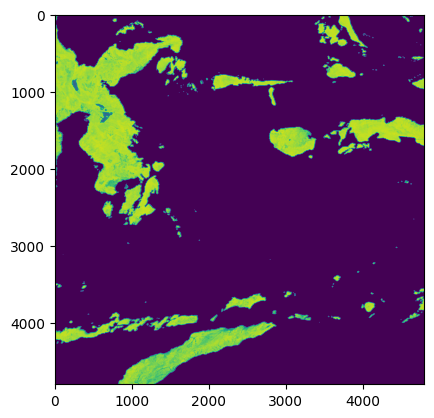

In [2]:
import matplotlib.pyplot as plt
plt.imshow(out_array.reshape(out_array.shape[0], x_size, y_size)[0])
plt.show()

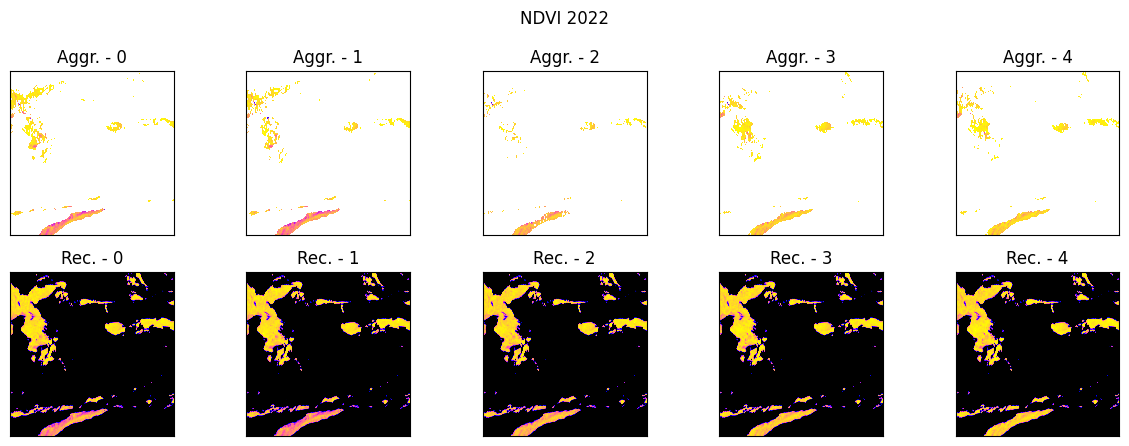

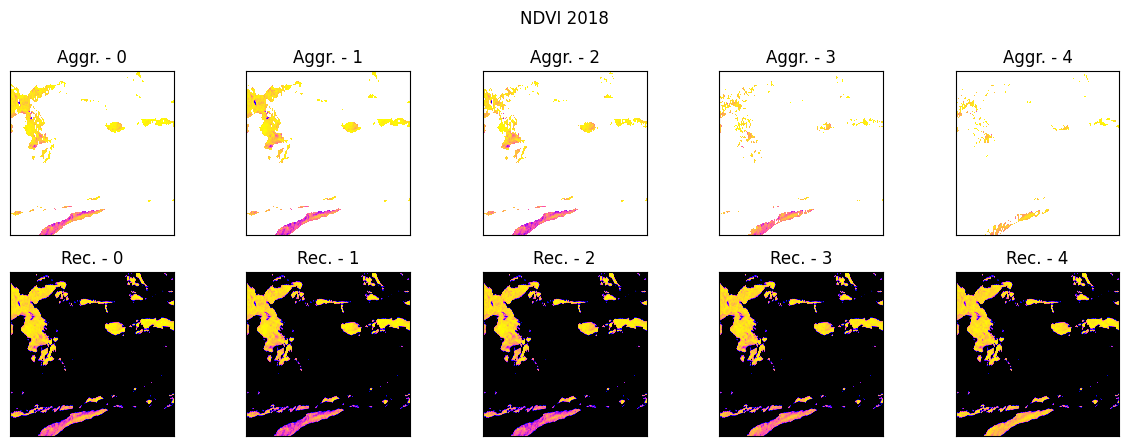

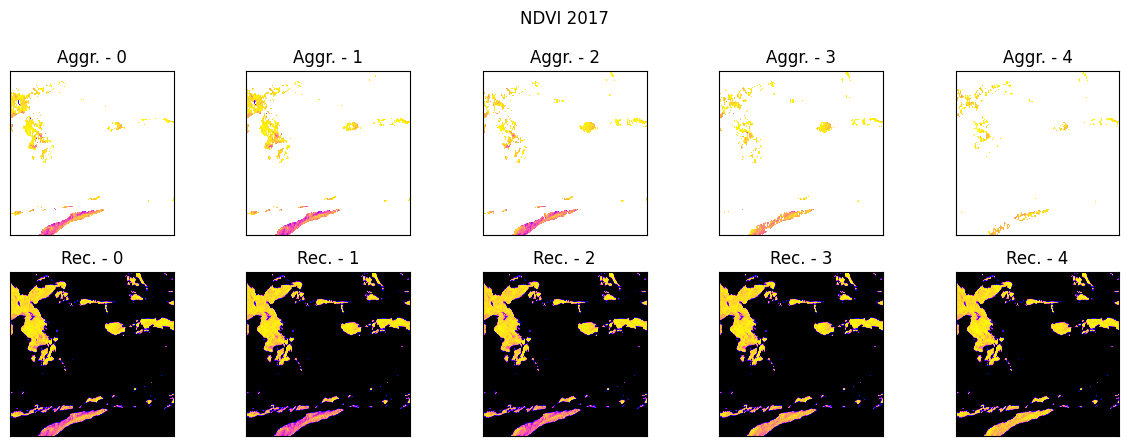

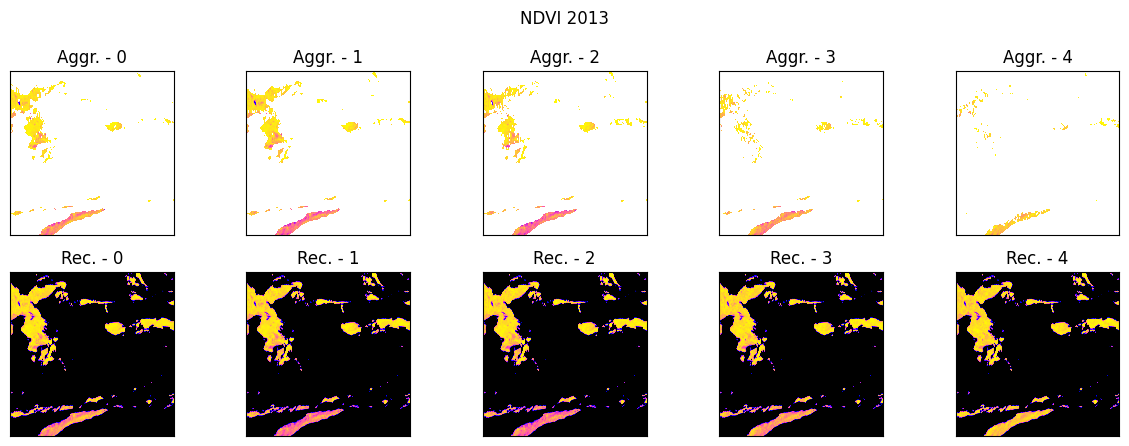

In [3]:
import matplotlib.pyplot as plt
agg_array = np.empty((n_out_files, x_size * y_size), dtype=np.float32)
skmap_bindings.transposeArray(agg_array_t, n_threads, agg_array)
data_to_plot = (agg_array,out_array,)
var_names = ("Aggr.", "Rec.")
stop_month = 5
for year in [2022, 2018, 2017, 2013]:
    fig, axes = plt.subplots(len(data_to_plot), stop_month, figsize=(12, 2*len(data_to_plot)+0.5))
    for i, tmp_data in enumerate(data_to_plot):
        start_index = n_out_files - stop_month - n_im_per_year_agg * (end_year-year)        
        for j in range(stop_month):
            axes[i, j].imshow(tmp_data.reshape(tmp_data.shape[0], x_size, y_size)[start_index + j], cmap='gnuplot2', vmin=-2000, vmax=10000)
            axes[i, j].set_title(f"{var_names[i]} - {j}")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    fig.suptitle(f"NDVI {year}")
    plt.tight_layout()
    plt.show()